# Using Cross-Validation with `linea`

In this notebook, we will demonstrate using `linea` to use linear regression and find the best/optimal set of linear detrending vectors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from linea import CheopsLightCurve, linalg, Planet
from astropy.table import Table
import os
from gpcheops import utils

Let's first visualise the data...

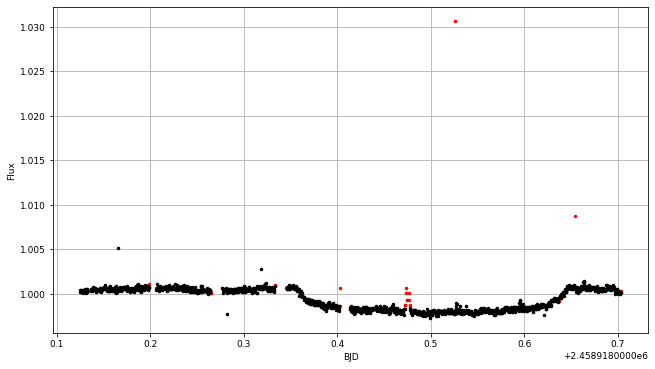

In [2]:
# Planetary parameters
per = 4.73620495
bjd0 = 2458918.50187268
inc1 = 88.3881899981
rprs = 0.0453073686
ar = 5.2012945357
bb = ar * np.cos(np.radians(inc1))
t14 = utils.tdur(per, ar, rprs, bb)

# Load the transit parameters for HD 189733
p = Planet(per=per, t0=bjd0, inc=inc1, rp=rprs, ecc=0., w=90.,
                 a=ar, u=[0.516,0.086])#, fp=1e-6, t_secondary=bjd0 + (per/2))

lc = CheopsLightCurve.from_fits(os.getcwd() + '/Data/kelt-11.fits')

msk1 = np.zeros(len(lc.bjd_time), dtype=bool)
msk2 = np.where((lc.bjd_time > bjd0 - (t14/2))&(lc.bjd_time < bjd0 + (t14/2)))[0]
for i in range(len(msk2)):
    msk1[msk2[i]] = True

plt.figure(figsize=(16/1.5, 9/1.5))
lc.sigma_clip_flux(sigma_upper=5, sigma_lower=5, plot=True)
lc.mask |= msk1
plt.grid()
plt.show()

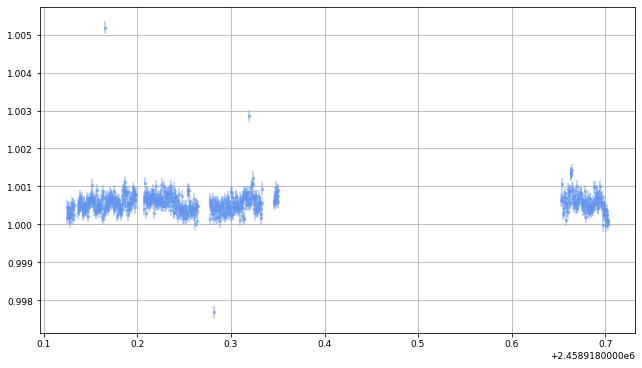

In [3]:
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(lc.bjd_time[~lc.mask], lc.flux[~lc.mask], yerr=lc.fluxerr[~lc.mask], fmt='.', c='cornflowerblue', alpha=0.5)
plt.grid()

In [4]:
# Design matrix
xc, nme = lc.design_matrix_all(5, False)

In [5]:
# Performing Cross-Validation
lams = np.linspace(1,10,10)
train_loss = np.zeros((50, 10))
test_loss = np.zeros((50, 10))

for i in range(50):
    tim, fl, fle = lc.bjd_time[~lc.mask], lc.flux[~lc.mask], lc.fluxerr[~lc.mask]
    # Mask for train data (30% of the points)
    msk2 = np.random.choice(np.arange(len(tim)), int(len(tim)*0.3), replace=False)
    msk1 = np.zeros(len(tim), dtype=bool)
    for k in range(len(msk2)):
        msk1[msk2[k]] = True
    # Train set and test set
    xc_trn, fl_trn, fle_trn = xc[msk1], fl[msk1], fle[msk1]
    xc_tst, fl_tst, fle_tst = xc[~msk1], fl[~msk1], fle[~msk1]
    for j in range(10):
        # Regularisation vector
        log_lam = np.hstack([-np.inf, lams[j]*np.ones(len(xc_trn[0,:]) - 1)])
        bet_trn, _ = linalg.linreg(xc_trn, fl_trn, fle_trn, log_lam)
        model_trn = xc_trn @ bet_trn
        resid_trn = ((fl_trn - model_trn)/fle_trn)**2
        train_loss[i, j] = np.log(np.sum(resid_trn))
        ### Doing the same for test set
        ### Here we won't compute GLS, but will use weights from training set
        model_tst = xc_tst @ bet_trn
        resid_tst = ((fl_tst-model_tst)/fle_tst)**2
        test_loss[i, j] = np.log(np.sum(resid_tst))

In [6]:
tst_loss_med = np.median(test_loss, axis=0)
trn_loss_med = np.median(train_loss, axis=0)

min_chi_tst_arg = np.argmin(tst_loss_med)
min_chi_trn_arg = np.argmin(trn_loss_med)

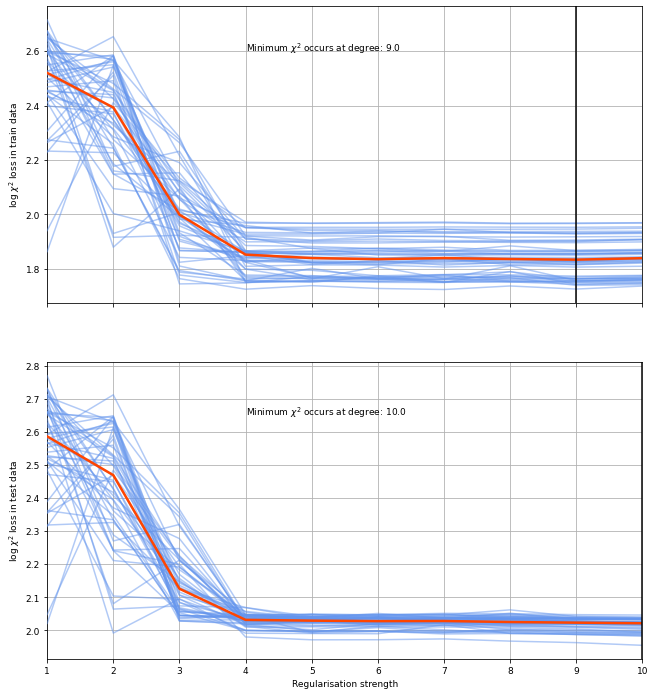

In [7]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16/1.5,18/1.5))

for i in range(50):
    ax[0].plot(lams, np.log(train_loss[i,:]), color='cornflowerblue', alpha=0.5, zorder=5)
    ax[1].plot(lams, np.log(test_loss[i,:]), color='cornflowerblue', alpha=0.5, zorder=5)

ax[0].plot(lams, np.log(trn_loss_med), color='orangered', lw=2.5, zorder=10)
ax[1].plot(lams, np.log(tst_loss_med), color='orangered', lw=2.5, zorder=10)

ax[0].axvline(lams[min_chi_trn_arg], color='k', lw=1.5, zorder=10)
ax[1].axvline(lams[min_chi_tst_arg], color='k', lw=1.5, zorder=10)

ax[0].set_xlim([1,10])
ax[1].set_xlim([1,10])

ax[0].text(4, 2.60, r'Minimum $\chi^2$ occurs at degree: ' + str(lams[min_chi_trn_arg]))
ax[1].text(4, 2.65, r'Minimum $\chi^2$ occurs at degree: ' + str(lams[min_chi_tst_arg]))

ax[1].set_xlabel('Regularisation strength')
ax[0].set_ylabel(r'log $\chi^2$ loss in train data')
ax[1].set_ylabel(r'log $\chi^2$ loss in test data')

ax[0].grid()
ax[1].grid()

In [8]:
regl2 = np.hstack([-np.inf, 10*np.ones(len(xc[0,:]) - 1)])
r1 = lc.regress(xc, regl2)

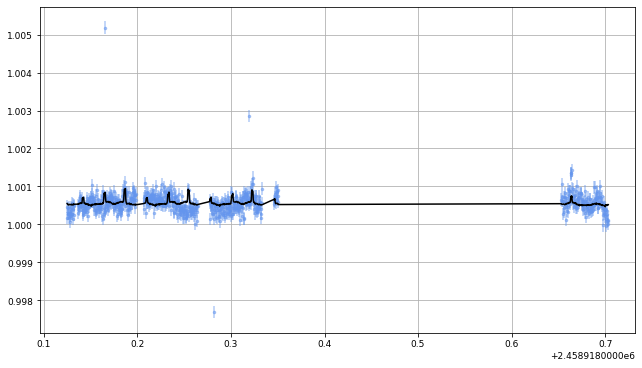

In [9]:
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(lc.bjd_time[~lc.mask], lc.flux[~lc.mask], yerr=lc.fluxerr[~lc.mask], fmt='.', c='cornflowerblue', alpha=0.5)
plt.plot(lc.bjd_time[~lc.mask], r1.best_fit, color='k', zorder=10, lw=1.5)
plt.grid()

In [10]:
tab = Table()
tab['Name'] = nme
tab['Param'] = r1.betas
tab['Err'] = np.sqrt(np.diagonal(r1.cov))

tab.pprint_all()

     Name              Param                   Err          
------------- ----------------------- ----------------------
         ones       1.006922182710678   0.008693018391398598
         sin1   8.944796452574344e-06  6.978078337180311e-06
         cos1  1.5203329730975688e-05  6.590620876501189e-06
         sin2   5.240474372712441e-06  6.778002952758027e-06
         cos2   4.439740020874402e-06  6.589346834799147e-06
         sin3 -1.7145563778187206e-05  6.838562632464151e-06
         cos3 -1.3352800663120334e-06 6.7889981551261705e-06
         sin4  -6.586672094548209e-06  6.696432543051456e-06
         cos4 -2.5882410445410807e-06  6.625994296603583e-06
         sin5 -1.2946930947081367e-05  6.654523999179769e-06
         cos5   3.634107155333407e-06  6.668183773535847e-06
           xc  1.5652197165758882e-08  9.999997961179618e-06
           yc  -6.010748019976901e-09  9.999994451363477e-06
           x2  -3.858731158893117e-07  9.253142532261429e-07
           y2 -3.1458901